# Pytorchを用いた時系列予測 〜Seq2Seq編〜 公開ノートブック

### 初期設定

In [1]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#ランダムシードの設定
fix_seed = 0
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

#デバイスの設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')

### データのロードと実験用の成形

In [2]:
class AirPassengersDataset(Dataset):
    def __init__(self, flag, seq_len, pred_len):
        #学習期間と予測期間の設定
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        #訓練用、評価用、テスト用を分けるためのフラグ
        type_map = {'train': 0, 'val': 1, 'test':2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        
        #seabornのデータセットから飛行機の搭乗者数のデータをロード
        df_raw = sns.load_dataset('flights')

        #訓練用、評価用、テスト用で呼び出すデータを変える
        border1s = [0, 12 * 9 - self.seq_len, 12 * 11 - self.seq_len]
        border2s = [12 * 9, 12 * 11, 12 * 12]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        data = df_raw[['passengers']].values

        self.data = data[border1:border2]

    def __getitem__(self, index):
        #学習用の系列と予測用の系列を出力
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        src = self.data[s_begin:s_end]
        tgt = self.data[r_begin:r_end]

        return src, tgt
    
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

### DataLoaderの定義

In [3]:
def data_provider(flag, seq_len, pred_len, batch_size):
    #flagに合ったデータを出力
    data_set = AirPassengersDataset(flag=flag, 
                                    seq_len=seq_len, 
                                    pred_len=pred_len
                                   )
    #データをバッチごとに分けて出力できるDataLoaderを使用
    data_loader = DataLoader(data_set,
                             batch_size=batch_size, 
                             shuffle=True
                            )
    
    return data_loader

### Seq2Seqの定義

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, d_model, d_input, d_output, dropout = 0.1):
        super(Seq2Seq, self).__init__()
        
        #エンコーダのLSTM
        self.enc_lstm = nn.LSTM(d_input, d_model, batch_first=True, dropout=dropout)
        
        #デコーダのLSTM
        self.dec_lstm = nn.LSTM(d_output, d_model, batch_first=True, dropout=dropout)
        
        #全結合層
        self.output = nn.Linear(d_model, d_output)

    def forward(self, src, input_tgt):
        #hiddenとcontextのみ出力
        _, (h, c) = self.enc_lstm(src)
        
        #hiddenとcontextを用いてinput_tgtを予測
        output, _ = self.dec_lstm(input_tgt, (h, c))
        
        output = self.output(output)
        
        return output

### 訓練、評価、予測の処理を定義

In [5]:
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for src, tgt in data_provider:
        #元データがintなのでfloatに変換
        src = src.float().to(device)
        tgt = tgt.float().to(device)
        
        #デコーダの入力
        input_tgt = torch.cat((src[:,-1:,:], tgt[:,:-1,:]), dim=1)

        output = model(src=src, input_tgt=input_tgt)

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())

        optimizer.step()
        
    return np.average(total_loss)


def evaluate(model, data_provider, criterion):
    model.eval()
    total_loss = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)
        
        input_tgt = torch.cat((src[:,-1:,:], tgt[:,:-1,:]), dim=1)

        output = model(
            src=src, input_tgt=input_tgt
        )
        
        loss = criterion(output, tgt)
        total_loss.append(loss.cpu().detach())
        
    return np.average(total_loss)

def predict(model, data_provider, criterion):
    model.eval()
    #テスト用データは一つなのでforを使わず一つだけ出す
    src, tgt = data_provider.__iter__().next()
    src = src.float().to(device)
    tgt = tgt.float().to(device)
    
    #エンコーダからhiddenとcontextを出力
    _, (h, c) = model.enc_lstm(src.float().to(device))
    
    #ループさせて次々に予測
    input_tgt = src[:,-1:,:].float().to(device)
    output = torch.Tensor().to(device)
    
    for i in range(tgt.size(1)):
        
        input_tgt, (h, c) = model.dec_lstm(input_tgt, (h, c))
        input_tgt = model.output(input_tgt)
        
        output = torch.cat((output, input_tgt), dim=1)
    
    #予測結果を画像にする
    true = torch.cat((src, tgt), dim=1)
    pred = torch.cat((src, output), dim=1)
    plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
    plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
    plt.legend()
    plt.savefig('test.pdf')
    
    return criterion(output, tgt)

### パラメータなどの定義

In [6]:
d_input = 1
d_output = 1
d_model = 512
dropout = 0.1
src_len = 36
tgt_len = 12
batch_size = 1
epochs = 200
best_loss = float('Inf')
best_model = None

model = Seq2Seq(
    d_model=d_model,
    d_input=d_input, d_output=d_output,
    dropout=dropout
)

#パラメータの初期化
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.RAdam(model.parameters())

### 訓練

In [7]:
for epoch in range(1, epochs + 1):
    
    #訓練
    loss_train = train(model=model, 
                       data_provider=data_provider('train', src_len, tgt_len, batch_size), 
                       optimizer=optimizer, 
                       criterion=criterion
                      )
    #評価
    loss_valid = evaluate(model=model, 
                          data_provider=data_provider('val', src_len, tgt_len, batch_size), 
                          criterion=criterion
                         )
    
    
    if epoch%20==0:
        print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}'.format(
            epoch, epochs,
            loss_train, loss_valid,
        ))
    
    #評価用データに対する損失が最も小さいものを最も良いモデルとする
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0

[20/200] train loss: 898.80, valid loss: 8598.46
[40/200] train loss: 414.59, valid loss: 3982.71
[60/200] train loss: 270.39, valid loss: 2900.10
[80/200] train loss: 220.20, valid loss: 2509.56
[100/200] train loss: 174.19, valid loss: 2516.71
[120/200] train loss: 117.71, valid loss: 1723.91
[140/200] train loss: 100.28, valid loss: 1572.78
[160/200] train loss: 116.59, valid loss: 1908.99
[180/200] train loss: 86.13, valid loss: 1623.62
[200/200] train loss: 72.21, valid loss: 1573.37


### テスト用データにおける予測

tensor(7088.8867, device='cuda:0', grad_fn=<MseLossBackward0>)

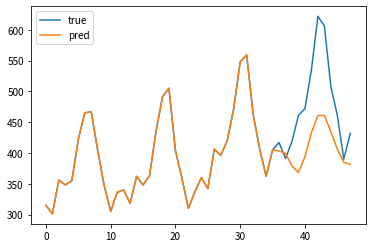

In [8]:
predict(model=best_model, data_provider=data_provider('test', src_len, tgt_len, batch_size), criterion=criterion)

### Qitta記事執筆に用いたもの（アーカイブ）

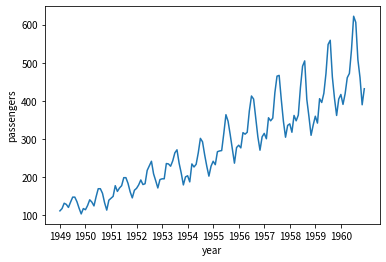

In [9]:
#データ可視化
data = sns.load_dataset('flights')
plt.plot(data['passengers'].values)
plt.xlabel('year')
plt.ylabel('passengers')
plt.xticks(np.arange(0,144,12), range(1949,1961))
plt.savefig('air_passengers.pdf')

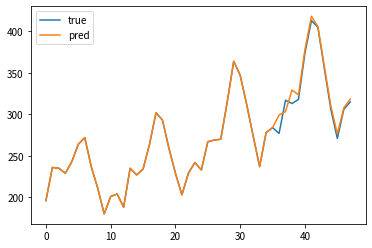

In [10]:
#学習用データでのパフォーマンス
src, tgt = data_provider('train', src_len, tgt_len, batch_size).__iter__().next()
src = src.float().to(device)
tgt = tgt.float().to(device)

input_tgt = torch.cat((src[:,-1:,:], tgt[:,:-1,:]), dim=1)
_, (h, c) = best_model.enc_lstm(src)
output, _ = best_model.dec_lstm(input_tgt, (h,c))
output = best_model.output(output)

true = torch.cat((src, tgt), dim=1)
pred = torch.cat((src, output), dim=1)
plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
plt.legend()
plt.savefig('train.pdf')

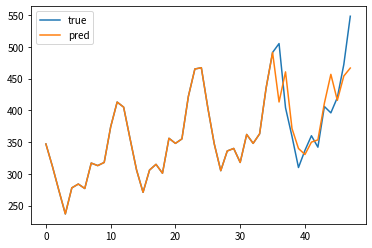

In [11]:
#評価用データでのパフォーマンス
src, tgt = data_provider('val', src_len, tgt_len, batch_size).__iter__().next()
src = src.float().to(device)
tgt = tgt.float().to(device)


input_tgt = torch.cat((src[:,-1:,:], tgt[:,:-1,:]), dim=1)
_, (h, c) = best_model.enc_lstm(src)
output, _ = best_model.dec_lstm(input_tgt, (h,c))
output = best_model.output(output)

true = torch.cat((src, tgt), dim=1)
pred = torch.cat((src, output), dim=1)
plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
plt.legend()
plt.savefig('val.pdf')

In [12]:
#input_tgtの最初を0にしたバージョン->こっちの方が精度低い
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for src, tgt in data_provider:
        #元データがintなのでfloatに変換
        src = src.float().to(device)
        tgt = tgt.float().to(device)
        
        #デコーダの入力
        zeros = torch.zeros(tgt.size(0),1,tgt.size(2)).float().to(device)
        input_tgt = torch.cat((zeros, tgt[:,:-1,:]), dim=1)

        output = model(src=src, input_tgt=input_tgt)

        optimizer.zero_grad()

        loss = criterion(output, tgt)
        loss.backward()
        total_loss.append(loss.cpu().detach())

        optimizer.step()
        
    return np.average(total_loss)


def evaluate(model, data_provider, criterion):
    model.eval()
    total_loss = []
    for src, tgt in data_provider:
        
        src = src.float().to(device)
        tgt = tgt.float().to(device)
        
        zeros = torch.zeros(tgt.size(0),1,tgt.size(2)).float().to(device)
        input_tgt = torch.cat((zeros, tgt[:,:-1,:]), dim=1)

        output = model(
            src=src, input_tgt=input_tgt
        )
        
        loss = criterion(output, tgt)
        total_loss.append(loss.cpu().detach())
        
    return np.average(total_loss)

def predict(model, data_provider, criterion):
    model.eval()
    #テスト用データは一つなのでforを使わず一つだけ出す
    src, tgt = data_provider.__iter__().next()
    src = src.float().to(device)
    tgt = tgt.float().to(device)
    
    #エンコーダからhiddenとcontextを出力
    _, (h, c) = model.enc_lstm(src.float().to(device))
    
    #ループさせて次々に予測
    input_tgt = torch.zeros(tgt.size(0),1,tgt.size(2)).float().to(device)
    output = torch.Tensor().to(device)
    
    for i in range(tgt.size(1)):
        
        input_tgt, (h, c) = model.dec_lstm(input_tgt, (h, c))
        input_tgt = model.output(input_tgt)
        
        output = torch.cat((output, input_tgt), dim=1)
    
    #予測結果を画像にする
    true = torch.cat((src, tgt), dim=1)
    pred = torch.cat((src, output), dim=1)
    plt.plot(true.squeeze().cpu().detach().numpy(), label='true')
    plt.plot(pred.squeeze().cpu().detach().numpy(), label='pred')
    plt.legend()
    plt.savefig('test_.pdf')
    
    return criterion(output, tgt)

In [13]:
d_input = 1
d_output = 1
d_model = 512
dropout = 0.1
src_len = 36
tgt_len = 12
batch_size = 1
epochs = 200
best_loss = float('Inf')
best_model = None

model = Seq2Seq(
    d_model=d_model,
    d_input=d_input, d_output=d_output,
    dropout=dropout
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.RAdam(model.parameters())

In [ ]:
for epoch in range(1, epochs + 1):
    
    #訓練
    loss_train = train(model=model, 
                       data_provider=data_provider('train', src_len, tgt_len, batch_size), 
                       optimizer=optimizer, 
                       criterion=criterion
                      )
    #評価
    loss_valid = evaluate(model=model, 
                          data_provider=data_provider('val', src_len, tgt_len, batch_size), 
                          criterion=criterion
                         )
    
    if epoch%20==0:
        print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}'.format(
            epoch, epochs,
            loss_train, loss_valid,
        ))
    
    #評価用データに対する損失が最も小さいものを最も良いモデルとする
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0

[20/200] train loss: 937.87, valid loss: 8289.08
[40/200] train loss: 432.99, valid loss: 4523.96
[60/200] train loss: 246.56, valid loss: 2905.23
[80/200] train loss: 216.34, valid loss: 2229.38


In [ ]:
predict(model=best_model, data_provider=data_provider('test', src_len, tgt_len, batch_size), criterion=criterion)